In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, TabPanel, Tabs
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span


In [11]:
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [12]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(ooklaUsers,title, source, earthquakes=False, subtitle=None, measure = 'conflictIndex', category = 'DT'):

    p2 = figure(x_axis_type = 'datetime', width = 1000, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(ooklaUsers[category].unique()):
        df = ooklaUsers[ooklaUsers[category]==adm2][['event_date', measure]].reset_index(drop=True)
        p2.line(df['event_date'], df[measure], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "20pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    if earthquakes:
        p2.renderers.extend([
        Span(
            location=datetime(2020, 3, 15),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
      ),
        Span(
            location=datetime(2021, 2, 15),
            dimension="height",
            line_color='#7C7C7C',
            line_width=2,
            line_dash=(4,4)
        ),
    ]
)

    return layout

# Armed Conflict Location and Event Data Analysis

The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated data collection, analysis, and crisis mapping project. ACLED collects information on the dates, actors, locations, fatalities, and types of all reported political violence and protest events around the world. The raw data is available through a license obtained by the World Bank

In [32]:
myanmar_adm3 = gpd.read_file('../../data/shapefiles/mmr_polbnda_adm3_250k_mimu/mmr_polbnda_adm3_250k_mimu.shp')
myanmar_adm2 = gpd.read_file('../../data/shapefiles/mmr_polbnda_adm2_250k_mimu_1/mmr_polbnda_adm2_250k_mimu_1.shp')
myanmar_adm1 = gpd.read_file('../../data/shapefiles/mmr_polbnda2_adm1_250k_mimu/mmr_polbnda2_adm1_250k_mimu.shp')

sez = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019/industrial__special_economic_zones_sept2019.shp')
sez_hdx = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019_hdx/industrial__special_economic_zones_sept2019.shp')
ntl_sez = pd.read_csv('../../data/night-time-lights/admsez_VNP46A3.csv')
ntl_adm2 = pd.read_csv('../../data/night-time-lights/adm2_VNP46A3.csv')
ntl_adm3 = pd.read_csv('../../data/night-time-lights/adm3_VNP46A4.csv')
ntl_adm1 = pd.read_csv('../../data/night-time-lights/adm1_VNP46A3.csv')

acled = pd.read_csv('../../data/conflict/2012-01-01-2023-05-16-Myanmar.csv')
conflict = pd.read_csv('../../data/conflict/conflict_data_mmr.csv')

In [14]:
myanmar_sez = gpd.read_file('../../data/shapefiles/industrial__special_economic_zones_sept2019_hdx/industrial__special_economic_zones_sept2019.shp')

In [15]:
from datetime import datetime

acled['event_date'] = acled['event_date'].apply(lambda x: datetime.strptime(x, '%d %B %Y'))

Removing conflict data from strategic developments after the Mynmar Country team had consultations with a team onground monitoring the conflict

In [26]:
acled = acled[acled['event_type']!='Strategic developments']
acled = acled[acled['event_date']>='2020-01-01']

## Calculating Conflict Index

Conflict Index is calculated as a geometric mean of conflict events and fatalities at admin 2 level

In [17]:
from shapely.geometry import Point

def convert_to_gdf(df):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

    return gdf

In [18]:
import numpy as np
from scipy.stats import gmean

def get_acled_by_admin(myanmar_adm2, acled, columns = ['DT','DT_PCODE','ST'], nearest=False):
    acled_adm2 = convert_to_gdf(acled)
    if nearest == True:
        acled_adm2 = myanmar_adm2.sjoin_nearest(acled_adm2)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='M', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    else:
        acled_adm2 = myanmar_adm2.sjoin(acled_adm2)[[ 'event_date', 'fatalities', 'event_type' ]+columns].groupby([pd.Grouper(key='event_date', freq='M', closed='left')]+columns)['fatalities'].agg(['sum', 'count']).reset_index()
    acled_adm2.rename(columns = {'sum':'fatalities', 'count':'nrEvents'}, inplace=True)
    acled_adm2['conflictIndex'] = acled_adm2.apply(lambda row: gmean([row['nrEvents'], row['fatalities']]), axis=1)
    acled_adm2['event_date_map'] = acled_adm2['event_date'].apply(lambda x: x.date().replace(day=1))

    return acled_adm2.reset_index()
#.pivot(index = 'DT_PCODE', columns='event_date').sort_values(by='DT_PCODE')

In [29]:
acled_adm1 = get_acled_by_admin(myanmar_adm1, acled, columns = ['ST', 'ST_PCODE'])
acled_adm2 = get_acled_by_admin(myanmar_adm2, acled)

c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
c:\Users\sahit\anaconda3\envs\turkey-rdna\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [28]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

tabs = []

tabs.append(
    TabPanel(
    child=get_line_plot(acled_adm1, f"Conflict Index by admin 1", "Source: ACLED", earthquakes=True, subtitle = '', category = 'ST'),
                #title=adm.capitalize(),
            )
            )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [30]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in list(acled_adm2['ST'].unique()):
    df = acled_adm2[acled_adm2['ST']==adm] 

    tabs.append(
        TabPanel(
        child=get_line_plot(df, f"Conflict Index by admin 2", "Source: ACLED", earthquakes=True, subtitle = ''),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Observe trends between nightlights and ACLED data

In [33]:
ntl_sez['date'] = ntl_sez['date'].apply(lambda x: datetime.strptime(x,  '%d/%m/%Y'))
ntl_adm1['date'] = ntl_adm1['date'].apply(lambda x: datetime.strptime(x,   '%Y-%m-%d'))
ntl_adm2['date'] = ntl_adm2['date'].apply(lambda x: datetime.strptime(x,   '%Y-%m-%d'))
ntl_adm2['date_map'] = ntl_adm2['date'].apply(lambda x:x.date())

In [34]:
ntl_adm2['NAME_2'].replace({'Yangon-E':'Yangon (East)', 'Yangon-W':'Yangon (West)', 'Yangon-N':'Yangon (North)', 'Yangon-S':'Yangon (South)'}, inplace=True)

In [35]:
df = ntl_adm2.merge(acled_adm2, left_on = ['date_map', 'NAME_2'], right_on = ['event_date_map', 'DT'])

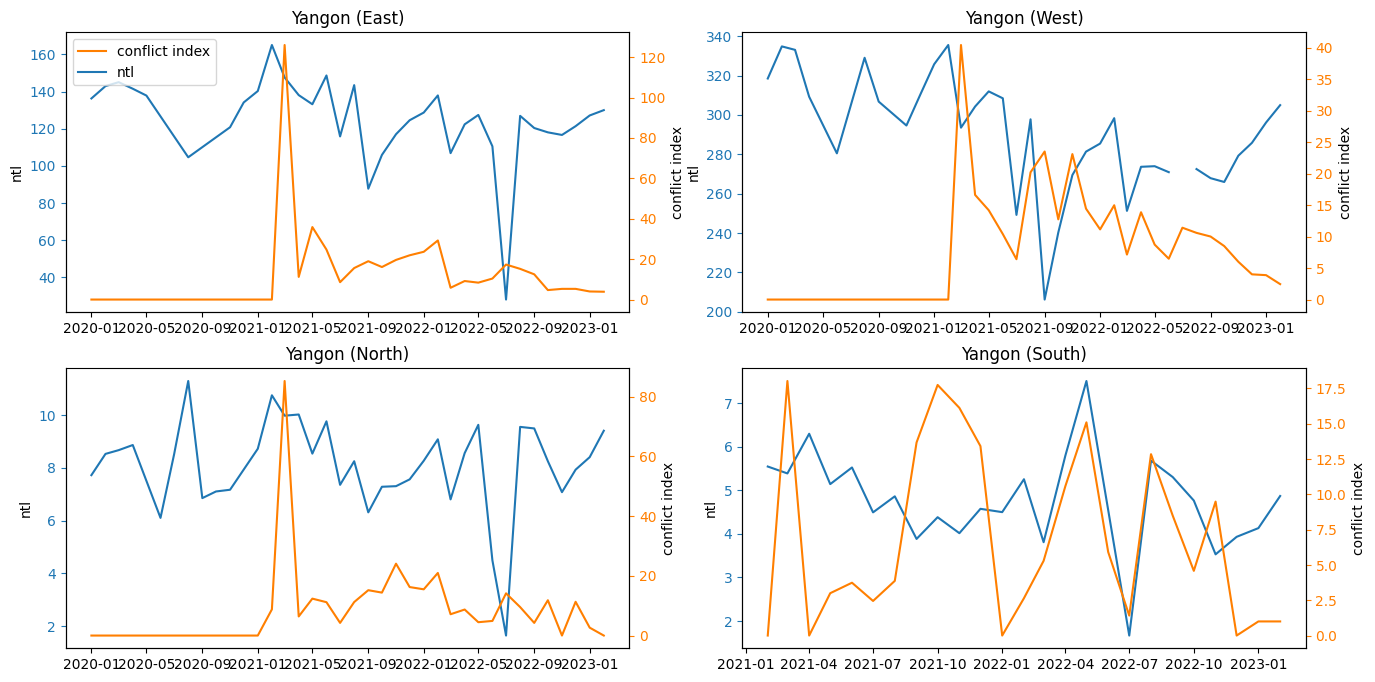

In [37]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
ax=axs.flatten()

for i, ST in enumerate(['Yangon (East)', 'Yangon (West)', 'Yangon (North)', 'Yangon (South)']):
    df1 = df[df['NAME_2']==ST]
    ax[i].plot(df1['date'], df1['ntl_bm_mean'], '#1F77B4',label = 'ntl')
    ax[i].set_ylabel('ntl')
    ax[i].tick_params('y', colors='#1F77B4')

    ax1 = ax[i].twinx()
    ax1.plot(df1['date'], df1['conflictIndex'], '#FF7F00', label='conflict index')
    ax1.set_xlabel('x')
    ax1.set_ylabel('conflict index')
    ax1.tick_params('y', colors='#FF7F00')

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    lines = ax1.get_lines() + ax[i].get_lines()
    labels = [line.get_label() for line in lines]
    ax[0].legend(lines, labels, loc='upper left')
    

    ax[i].set_title(ST)